In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dataset_path = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
# Filtrele: klasör isimlerinde nokta olmasın
fish_classes = [folder for folder in os.listdir(dataset_path) if '.' not in folder]
# Balık sınıflarını görüntüle
fish_classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [5]:
# Resim etiketlerini saklamak için liste
image_labels = []
# Resim dosya yollarını saklamak için liste
image_paths = []
# GT resim dosyası yollarını saklamak için liste
image_paths_gt = []

image_classes = np.array([[cls]*1000 for cls in fish_classes]).reshape(-1)

for current_dir, _, filenames in os.walk(dataset_path):
    # Alt dizin 'GT' değilse
    if current_dir.split() and current_dir.split()[-1] != 'GT':
        for filename in filenames:
            if os.path.splitext(filename)[-1].lower() == ".png":  # Sadece PNG dosyalarını kontrol et
                image_labels.append(os.path.split(current_dir)[-1])  # Alt dizin adını etiket olarak ekle
                image_paths.append(os.path.join(current_dir, filename))  # Dosya yolunu ekle
    # Eğer 'GT' dizini ise
    elif current_dir.split() and current_dir.split()[-1] == 'GT':
        for filename in filenames:
            if os.path.splitext(filename)[-1].lower() == ".png":  # Sadece PNG dosyalarını kontrol et
                # 'GT' dizinindeki resim yollarını ekle
                image_paths_gt.append(os.path.join(current_dir, filename))


In [6]:
data = pd.DataFrame({'path':image_paths, 'class':image_classes, })
data.head()

,path,class
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [7]:
data_gt = pd.DataFrame({'path':image_paths_gt, 'class':image_classes, })
data_gt.head()

,path,class
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [8]:
img_shape = (590 , 445, 3)

In [9]:
def get_generators(data, is_rgb =True):
    color_mode = 'rgb' if is_rgb else 'grayscale'
    data_full, data_remainder = train_test_split(data, stratify = data['class'], test_size = 0.2)
    train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.1)

    test_datagen = ImageDataGenerator(rescale = 1.0/255)
    train_generator = train_datagen.flow_from_dataframe(data_full, x_col='path', y_col='class',
        target_size=img_shape[:-1], color_mode=color_mode,
        class_mode='categorical', batch_size=32, shuffle=True,
        subset='training'
        )
    val_generator = train_datagen.flow_from_dataframe(data_full, x_col='path', y_col='class',
        target_size=img_shape[:-1], color_mode=color_mode,
        class_mode='categorical', batch_size=32, shuffle=True,
        subset='validation'
        )
    test_generator = test_datagen.flow_from_dataframe(data_remainder, x_col = 'path', y_col = 'class', target_size = img_shape[:-1], color_mode = color_mode,class_mode = 'categorical')
    return train_generator, val_generator, test_generator

In [10]:
train_gen, val_gen, test_gen = get_generators(data)

Found 6480 validated image filenames belonging to 9 classes.
Found 720 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense


model = Sequential([
    Conv2D(16,(3,3), strides = 3, input_shape = img_shape),
    MaxPooling2D(),
    Conv2D(32, (3,3),strides=2),
    
    MaxPooling2D(),
    Conv2D(64, (3,3)),
    MaxPooling2D(),
    Conv2D(64,(3,3)),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation = 'relu'),
    Dropout(0.5),
    Dense(9, activation = 'softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 36, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,689 (1014.41 KB)

 Trainable params: 259,689 (1014.41 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
earlystop = EarlyStopping(patience = 10,restore_best_weights=True )
schedule = ExponentialDecay(initial_learning_rate = 0.002, decay_steps = 1000, decay_rate = 0.7)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate =schedule), metrics = ['accuracy'])
history = model.fit(train_gen, validation_data = val_gen,epochs = 100, callbacks = [earlystop])

Epoch 1/100


I0000 00:00:1729546627.011094      94 service.cc:145] XLA service 0x7c6a7c002830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729546627.011161      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/203 ━━━━━━━━━━━━━━━━━━━━ 44:34 13s/step - accuracy: 0.1562 - loss: 2.3215

I0000 00:00:1729546632.382170      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/203 ━━━━━━━━━━━━━━━━━━━━ 178s 816ms/step - accuracy: 0.3349 - loss: 1.7858 - val_accuracy: 0.7222 - val_loss: 0.7880
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 530ms/step - accuracy: 0.6648 - loss: 0.9290 - val_accuracy: 0.8694 - val_loss: 0.4334
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 531ms/step - accuracy: 0.7803 - loss: 0.6099 - val_accuracy: 0.9181 - val_loss: 0.2497
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 112s 533ms/step - accuracy: 0.8468 - loss: 0.4332 - val_accuracy: 0.9056 - val_loss: 0.2713
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 528ms/step - accuracy: 0.8774 - loss: 0.3338 - val_accuracy: 0.9236 - val_loss: 0.2222
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 531ms/step - accuracy: 0.8958 - loss: 0.3012 - val_accuracy: 0.9736 - val_loss: 0.0832
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 111s 530ms/step - accuracy: 0.9242 - loss: 0.2385 - val_accuracy: 0.9667 - val_loss: 0.0958
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 115s 550ms/step - accuracy: 0.9337 - los

In [13]:
model.evaluate(test_gen)

57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 736ms/step - accuracy: 0.9985 - loss: 0.0050


[0.004332561511546373, 0.9983333349227905]

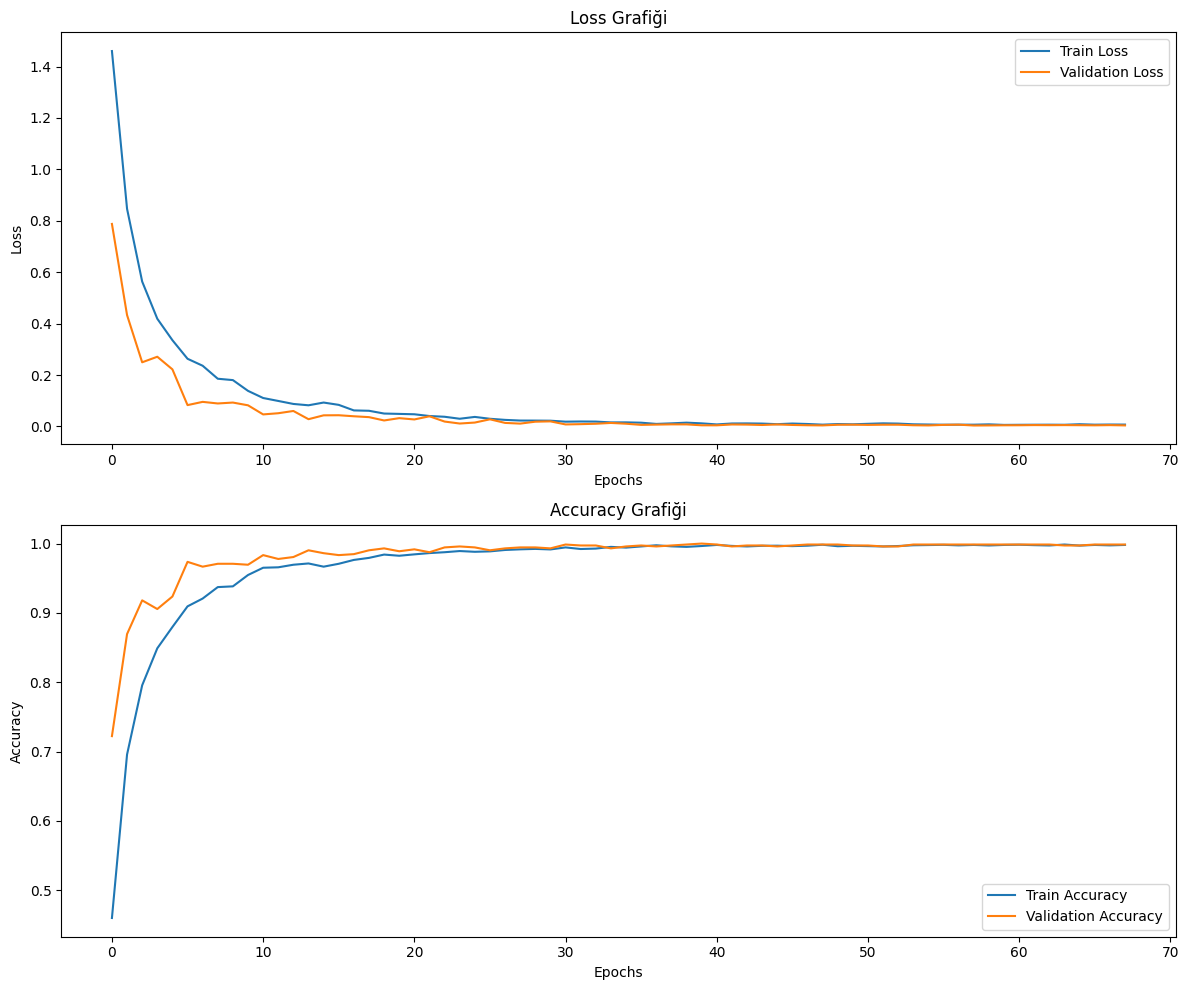

In [30]:
plt.figure(figsize=(12, 10))  # Yüksekliği artırdık

# Loss değeri için grafikleri çizdirelim.
plt.subplot(2, 1, 1)  # 2 satır, 1 sütun, 1. grafik
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy score grafikleri çizdirelim.
plt.subplot(2, 1, 2)  # 2 satır, 1 sütun, 2. grafik
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()